In [116]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import random
import pandas as pd
import multiprocessing as mp
import numpy as np

from data_utils import *

import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from acp import *

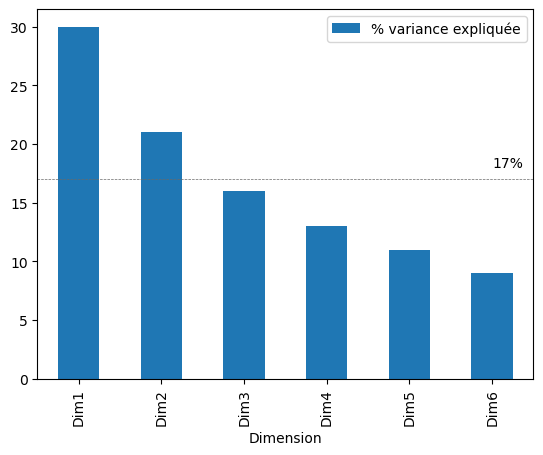

  Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0      Dim1            1.776507                  30.0                   30.0
1      Dim2            1.267228                  21.0                   51.0
2      Dim3            0.985160                  16.0                   67.0
3      Dim4            0.799718                  13.0                   80.0
4      Dim5            0.633279                  11.0                   91.0
5      Dim6            0.538836                   9.0                  100.0
8232


In [117]:
### SCRIPT ###

edges_all_prop_path = "../../../score_calculation/sample_analyse/sample_data/edges_all_prop_sample.gpkg"

edges_all_prop = gpd.read_file(edges_all_prop_path)
features = ["prairies_prop", "arbustes_prop", "arbres_prop", "C_wavg_scaled", "eaux_prop", "canop"]

prop_pca = pca_pipeline(edges_all_prop, features, 6)
eig_prop_pca = eigein_values(prop_pca, plot=True)
coord = coord_pca(edges_all_prop[features], prop_pca)
print(len(coord)) # 8232

In [12]:
prop_pca.explained_variance_ratio_

array([0.29604858, 0.21117905, 0.16417336, 0.13327021, 0.10553372,
       0.08979506])

In [59]:
def plot_ind_pca(data, pca, nbre_dim=2, method="plotly", dim=[1, 2]):
    coord = coord_pca(data, pca)[:,0:nbre_dim]
    if(method == "plotly"):
        labels = {
            str(i): f"PC {i+1} ({var:.1f}%)"
            for i, var in enumerate(pca.explained_variance_ratio_[:nbre_dim] * 100)
        }

        fig = px.scatter_matrix(
            coord,
            labels=labels,
            dimensions=range(nbre_dim),
        )
        fig.update_traces(diagonal_visible=False)
        fig.show()
    
    elif(method == "raw_plt"):
        coord_df = pd.DataFrame({
            f"Dim{dim[0]}" : coord[:, dim[0]-1],
            f"Dim{dim[1]}": coord[:, dim[1]-1]
        })
        coord_df.plot.scatter(f"Dim{dim[0]}", f"Dim{dim[1]}")
        plt.xlabel(f"Dimension {dim[0]} {round(pca.explained_variance_ratio_[dim[0]-1]*100, 2)}%")
        plt.ylabel(f"Dimension {dim[1]} {round(pca.explained_variance_ratio_[dim[1]-1]*100, 2)}%")
        plt.show()

In [64]:
plot_ind_pca(edges_all_prop[features], prop_pca, nbre_dim=3)

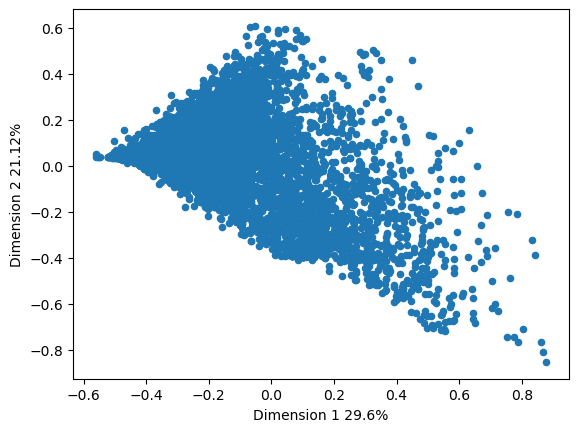

In [60]:
plot_ind_pca(edges_all_prop[features], prop_pca, method="raw_plt", dim=[1,2])

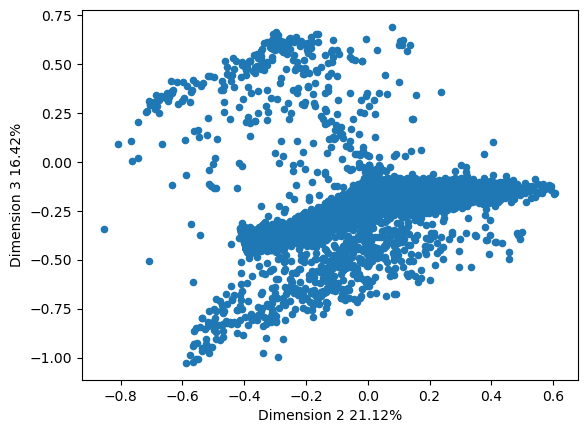

In [63]:
plot_ind_pca(edges_all_prop[features], prop_pca, nbre_dim=3, method="raw_plt", dim=[2,3])

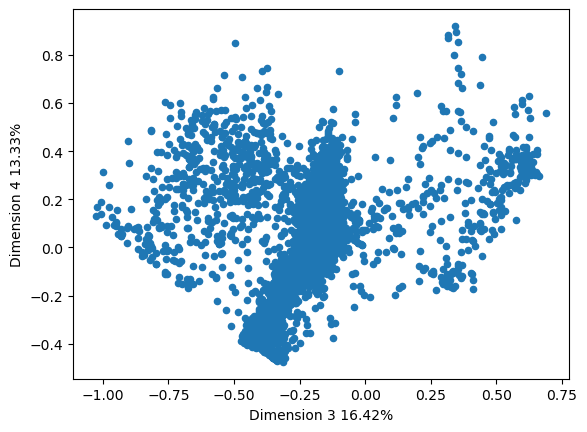

In [65]:
plot_ind_pca(edges_all_prop[features], prop_pca, nbre_dim=4, method="raw_plt", dim=[3,4])

In [68]:
def coord_var_pca(data, pca, dim=[1,2]):
    n = data.shape[0]
    p = data.shape[1]
    eigval = (n-1)/n * pca.explained_variance_
    sqrt_eigval = np.sqrt(eigval)
    corvar = np.zeros((p,p))
    for k in range(p):
        corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
    
    coordvar = pd.DataFrame({"id": data.columns, "COR_1": corvar[:,dim[0]-1], "COR_2": corvar[:,dim[1]-1]})

    return coordvar

In [94]:
def plot_var_circle(coordvar):
    # Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
    fig, axes = plt.subplots(figsize = (6,6))
    fig.suptitle("Cercle des corrélations")
    axes.set_xlim(-1, 1)
    axes.set_ylim(-1, 1)
    # Ajout des axes
    axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
    axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
    # Ajout des noms des variables
    for j in range(coordvar.shape[0]):
        axes.text(coordvar["COR_1"][j]+0.05,coordvar["COR_2"][j]+0.05, f"{coordvar['id'][j]} ({round(coordvar['COR_1'][j], 2)}, {round(coordvar['COR_2'][j], 2)})")
        axes.arrow(0,0,
                 coordvar["COR_1"][j],
                 coordvar["COR_2"][j],
                 lw = 2, # line width
                 length_includes_head=True, 
                 head_width=0.05,
                 head_length=0.05
                  )
    # Ajout du cercle
    plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

    plt.show()


              id     COR_1     COR_2
0  prairies_prop  0.450012 -0.012299
1  arbustes_prop  0.412062 -0.029642
2    arbres_prop  0.552038 -0.314447
3  C_wavg_scaled -0.786128 -0.218730
4      eaux_prop  0.462167  0.700692
5          canop  0.517343 -0.588491


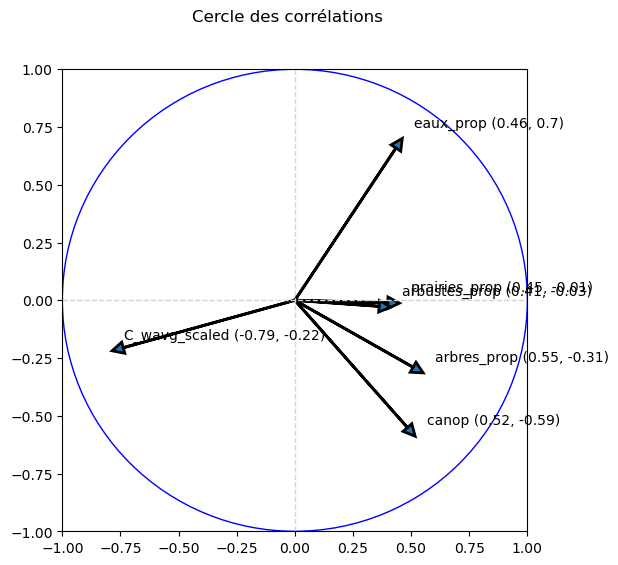

In [105]:
print(coord_var_pca(edges_all_prop[features], prop_pca, dim=[1,3]))
plot_var_circle(coord_var_pca(edges_all_prop[features], prop_pca, dim=[1,3]))

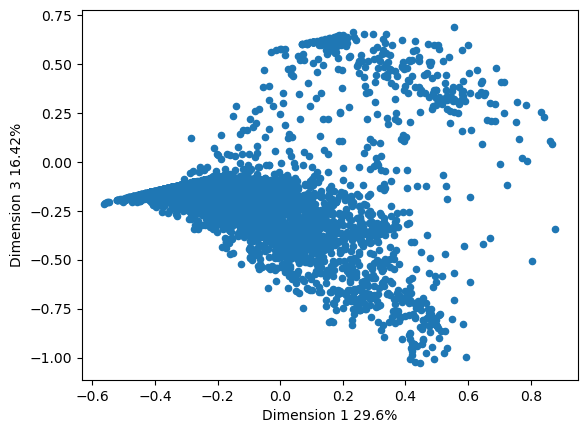

In [104]:
plot_ind_pca(edges_all_prop[features], prop_pca, nbre_dim=3, method="raw_plt", dim=[1,3])

In [128]:
def hclust_on_acp(data, pca, dt=0, n=None):
    hac = AgglomerativeClustering(distance_threshold=dt, n_clusters=n)
    pca_data = pca.transform(data)

    return(hac.fit(pca_data))

In [114]:
def plot_dendrogram(model, **kwargs):
    """Ne fonctionne que si distance_threshold != None donc n_clusters=None"""
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

AttributeError: 'AgglomerativeClustering' object has no attribute 'distances_'

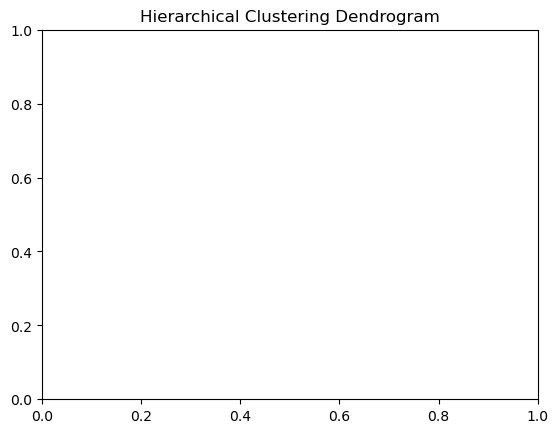

In [132]:
hclust = hclust_on_acp(edges_all_prop[features], prop_pca, dt=None, n=3)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(hclust, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [133]:
pd.Series(hclust.labels_).value_counts()

1    6062
0    1865
2     305
dtype: int64

In [135]:
data_pca_hclust = prop_pca.transform(edges_all_prop[features]).assign(hclust_classe = hclust.labels_)
data_pca_hclust

AttributeError: 'numpy.ndarray' object has no attribute 'assign'